In [1]:
# Import Libraries:

import numpy as np
import pandas as pd
import seaborn as sn
import xgboost as xgb
import lightgbm as lgb

import matplotlib
import matplotlib.pyplot as plt
#import graphviz
import shap
import sklearn

from sklearn import ensemble
from sklearn.inspection import plot_partial_dependence
from matplotlib.colors import ListedColormap
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from IPython.display import Image
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve
from sklearn.inspection import permutation_importance

# Susceptibility to induced seismicity 

## Geoscience BC project

In [2]:
df_well = pd.read_csv('GeologicalDB_Montney_Seismogenic.csv')
df_grid = pd.read_csv('MontneyGrid_GeologicalDB.csv')

## Data split and preprocessing (imputation and scaling)

In [3]:
train, test = train_test_split(df_well, test_size=0.25,random_state=12345) #splitting dataset (75% training size)
X_train = train.drop(columns=['Label','Montney-Mid','Lower_Form','Dist_Lower_Form','WellDensity-5km','Well_ID','LATITUDE','LONGITUDE'])
y_train = train['Label']
X_test = test.drop(columns=['Label','Montney-Mid','Lower_Form','Dist_Lower_Form','WellDensity-5km','Well_ID','LATITUDE','LONGITUDE'])
y_test = test['Label']


In [4]:
imputer = SimpleImputer(strategy="median")
imputer.fit(X_train)
X_train_imp = imputer.transform(X_train)
X_test_imp = imputer.transform(X_test)

scaler = StandardScaler() # create feature trasformer object
scaler.fit(X_train_imp) # fitting the transformer on the train split 
X_train_scaled = scaler.transform(X_train_imp) # transforming the train split
X_test_scaled = scaler.transform(X_test_imp) # transforming the test split

X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_test.columns)

## Data Before Scaling

In [11]:
pd.DataFrame(X_train, columns = X_train.columns).head()

,Bulk_Density,BHCPv,Gamma_Ray,b_value,Seismogenic_index,Shear_Strain,Shmin-Mpa,Shmax_variation,PP_grad,ppgrad_std,...,Max_Pb,Dist_TopMon,Dist_MidMon,Dist_Deb/Bell,Dist_Base,Montney-Thikness_CW,WellDensity-1km,WellDensity-3km,WellDensity-5km,WellDensity-10km
3278,2613.05,4818.33,129.99,1.011,-1.75,4.50,51.35,8.02,11.70,1.408559,...,56.53,216.15,116.14,-80.62,-1286.44,296.77,0,0,0,1
3717,2580.82,4918.76,110.63,0.909,-1.70,4.32,35.28,5.25,7.00,2.217854,...,44.20,218.87,107.95,-95.89,-1532.80,314.76,0,0,0,3
325,2556.44,5008.13,135.27,0.910,-1.68,4.41,40.52,3.36,12.38,0.880610,...,61.72,49.35,-22.21,-260.02,-1267.20,309.37,1,20,49,139
3246,2587.94,4743.47,114.94,1.005,-0.90,4.45,41.24,6.73,12.36,3.932977,...,58.10,95.16,7.24,-193.36,-1754.60,288.52,0,0,0,4
2516,2520.95,4988.64,134.87,0.913,-1.67,4.43,40.63,3.27,11.58,0.777588,...,58.00,257.28,84.76,-50.98,-1294.46,308.26,0,0,1,26


## Data After Scaling

In [12]:
pd.DataFrame(X_train_scaled, columns = X_train.columns).head()

,Bulk_Density,BHCPv,Gamma_Ray,b_value,Seismogenic_index,Shear_Strain,Shmin-Mpa,Shmax_variation,PP_grad,ppgrad_std,...,Max_Pb,Dist_TopMon,Dist_MidMon,Dist_Deb/Bell,Dist_Base,Montney-Thikness_CW,WellDensity-1km,WellDensity-3km,WellDensity-5km,WellDensity-10km
0,0.820194,-0.092609,0.454117,0.708688,-1.150418,0.175886,1.476698,1.156502,-0.402693,-0.348302,...,-0.055139,1.077899,1.173318,1.059092,1.430987,0.036378,-0.287957,-0.465226,-0.541942,-0.669914
1,0.154944,0.749573,-0.765508,-0.599700,-1.004960,-1.102320,-0.903746,0.003641,-3.121559,0.335259,...,-1.485485,1.105095,1.090991,0.907687,0.349623,0.697176,-0.287957,-0.465226,-0.541942,-0.641499
2,-0.348276,1.499008,0.786742,-0.586873,-0.946776,-0.463217,-0.127547,-0.782968,-0.009325,-0.794227,...,0.546929,-0.589861,-0.217388,-0.719694,1.515439,0.499193,0.287087,1.655092,1.626510,1.290671
3,0.301906,-0.720366,-0.493990,0.631724,1.322373,-0.179171,-0.020893,0.619610,-0.020895,1.783916,...,0.126990,-0.131827,0.078646,-0.058747,-0.623938,-0.266656,-0.287957,-0.465226,-0.541942,-0.627292
4,-1.080815,1.335570,0.761544,-0.548391,-0.917685,-0.321194,-0.111252,-0.820426,-0.472111,-0.881243,...,0.115389,1.489140,0.857883,1.352978,1.395785,0.458422,-0.287957,-0.465226,-0.497688,-0.314735


In [5]:
# Calculating Scores
scoring = "f1"
scoring_list = ["accuracy", "recall", "precision", "f1"] 

def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation
    """
    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)


results = dict()

In [7]:
scoring = "f1"
scoring_list = ["accuracy", "recall", "precision", "f1"] 

models = {
        
    
    'Dummy_Classifier'   : DummyClassifier(strategy="most_frequent"),
    'LogisticRegression' : LogisticRegression(class_weight="balanced"),
    'decision tree'      : DecisionTreeClassifier(class_weight="balanced"),
    'random forest'      : RandomForestClassifier(class_weight="balanced"),
    'SVC'                : SVC(class_weight="balanced"),
    'KNN'                : KNeighborsClassifier(), 
    'XGBoost'            : xgb.XGBClassifier()
#    'lightGBM'           : lgb.LGBClassifier() #### balanced class weight
         }

scores = dict()

for model_name, model in models.items():
#    print(model_name)
    scores[model_name] = mean_std_cross_val_scores(model, X_train_scaled, y_train, return_train_score=True, cv=5, scoring=scoring_list)

pd.DataFrame.from_dict(scores, orient='index')
#pd.DataFrame.from_dict(scores, orient='index').drop(columns=['fit_time','score_time','train_f1','train_precision','train_recall'])

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zer

[09:05:19] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[09:05:20] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:05:20] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[09:05:20] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:05:20] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,fit_time,score_time,test_accuracy,train_accuracy,test_recall,train_recall,test_precision,train_precision,test_f1,train_f1
Dummy_Classifier,0.001 (+/- 0.001),0.004 (+/- 0.001),0.801 (+/- 0.001),0.801 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000)
LogisticRegression,0.016 (+/- 0.002),0.006 (+/- 0.001),0.640 (+/- 0.026),0.646 (+/- 0.005),0.592 (+/- 0.056),0.625 (+/- 0.029),0.297 (+/- 0.023),0.308 (+/- 0.004),0.395 (+/- 0.029),0.412 (+/- 0.009)
decision tree,0.038 (+/- 0.005),0.005 (+/- 0.001),0.850 (+/- 0.016),1.000 (+/- 0.000),0.633 (+/- 0.032),1.000 (+/- 0.000),0.622 (+/- 0.050),1.000 (+/- 0.000),0.627 (+/- 0.035),1.000 (+/- 0.000)
random forest,0.489 (+/- 0.026),0.020 (+/- 0.001),0.891 (+/- 0.012),1.000 (+/- 0.000),0.584 (+/- 0.056),1.000 (+/- 0.000),0.821 (+/- 0.059),1.000 (+/- 0.000),0.681 (+/- 0.042),1.000 (+/- 0.000)
SVC,0.243 (+/- 0.007),0.108 (+/- 0.003),0.725 (+/- 0.020),0.773 (+/- 0.006),0.843 (+/- 0.027),0.948 (+/- 0.006),0.408 (+/- 0.019),0.465 (+/- 0.006),0.549 (+/- 0.018),0.624 (+/- 0.005)
KNN,0.003 (+/- 0.002),0.052 (+/- 0.005),0.842 (+/- 0.010),0.894 (+/- 0.005),0.530 (+/- 0.060),0.670 (+/- 0.020),0.622 (+/- 0.044),0.766 (+/- 0.015),0.569 (+/- 0.033),0.715 (+/- 0.016)
XGBoost,0.187 (+/- 0.011),0.007 (+/- 0.001),0.893 (+/- 0.008),1.000 (+/- 0.000),0.616 (+/- 0.063),1.000 (+/- 0.000),0.802 (+/- 0.026),1.000 (+/- 0.000),0.695 (+/- 0.036),1.000 (+/- 0.000)


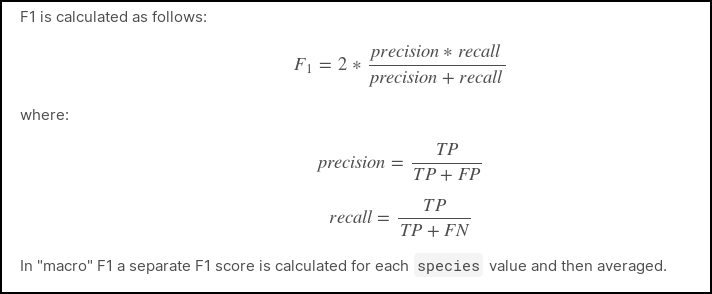

- Precision can be seen as a measure of quality, and recall (sensitivity) as a measure of quantity.
- Higher precision means that an algorithm returns more relevant results than irrelevant ones.
- high recall means that an algorithm returns most of the relevant results (whether or not irrelevant ones are also returned).

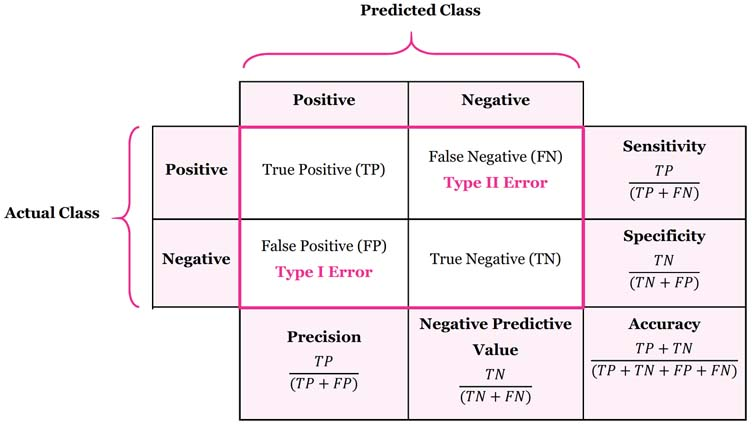

# Hyperparameter Optimization
- Bayesian search with Balanced class weight


In [6]:
import warnings
warnings.filterwarnings('ignore')
#### Logistic regression

optlr = BayesSearchCV(
    LogisticRegression(class_weight='balanced'),
    {
        'C': (1e-6, 1e+6, 'log-uniform'),
        'max_iter': (1e+2, 1e+5, 'log-uniform'),
    },
    n_iter=32,
    cv=5
)

optlr.fit(X_train_scaled, y_train)

print("LR train score: %s" % optlr.best_score_)
print("LR test score: %s" % optlr.score(X_test_scaled, y_test))
print("LR best params: %s" % str(optlr.best_params_))

##### Decision Tree

optdt = BayesSearchCV(
    DecisionTreeClassifier(),
    {
        'max_depth': (1, 100, 'log-uniform'),
    },
    n_iter=32,
    cv=5
)

optdt.fit(X_train_scaled, y_train)

print("DT train score: %s" % optdt.best_score_)
print("DT test score: %s" % optdt.score(X_test_scaled, y_test))
print("DT best params: %s" % str(optdt.best_params_))


##### Random Forest

optrf = BayesSearchCV(
    RandomForestClassifier(),
    {
        'max_depth': (1, 100, 'log-uniform'),
    },
    n_iter=32,
    cv=5
)

optrf.fit(X_train_scaled, y_train)

print("RF train score: %s" % optrf.best_score_)
print("RF test score: %s" % optrf.score(X_test_scaled, y_test))
print("RF best params: %s" % str(optrf.best_params_))


##### SVC
optsvc = BayesSearchCV(
    SVC(),
    {
        'C': (1e-6, 1e+6, 'log-uniform'),
        'gamma': (1e-6, 1e+1, 'log-uniform'),
        #'degree': (1, 8),  # integer valued parameter
        #'kernel': ['linear', 'poly', 'rbf'],  # categorical parameter
    },
    n_iter=32,
    cv=5
)

optsvc.fit(X_train_scaled, y_train)

print("SVC train score: %s" % optsvc.best_score_)
print("SVC test score: %s" % optsvc.score(X_test_scaled, y_test))
print("SVC best params: %s" % str(optsvc.best_params_))

###### KNN

optknn = BayesSearchCV(
    KNeighborsClassifier(),
    {
        'n_neighbors': (3, 10, 'log-uniform'),
        'leaf_size': (10, 50, 'log-uniform'),
    },
    n_iter=32,
    cv=5
)

optknn.fit(X_train_scaled, y_train)

print("KNN Opt train score: %s" % optknn.best_score_)
print("KNN Opt test score: %s" % optknn.score(X_test_scaled, y_test))
print("KNN Opt best params: %s" % str(optknn.best_params_))



LR train score: 0.6286664650740853
LR test score: 0.6355394378966455
LR best params: OrderedDict([('C', 0.016599520497738517), ('max_iter', 100.0)])
DT train score: 0.9029331720592683
DT test score: 0.9111514052583862
DT best params: OrderedDict([('max_depth', 38)])
RF train score: 0.9283338373147868
RF test score: 0.9265639165911151
RF best params: OrderedDict([('max_depth', 16)])
SVC train score: 0.9104928938615059
SVC test score: 0.9102447869446962
SVC best params: OrderedDict([('C', 114.80322823456191), ('gamma', 0.7148890027331399)])
KNN Opt train score: 0.9038403386755367
KNN Opt test score: 0.9174977334542158
KNN Opt best params: OrderedDict([('leaf_size', 37), ('n_neighbors', 8)])


In [15]:

optgb = BayesSearchCV(
    ensemble.GradientBoostingClassifier(),
    {
        'learning_rate': (1e-6, 0.9, 'log-uniform'),
        'n_estimators': (10, 1000, 'log-uniform'),
    },
    n_iter=32,
    cv=5
)

optgb.fit(X_train_scaled, y_train)

print("GB Opt train score: %s" % optgb.best_score_)
print("GB Opt test score: %s" % optgb.score(X_test_scaled, y_test))
print("GB Opt best params: %s" % str(optgb.best_params_))

GB Opt train score: 0.892651950408225
GB Opt test score: 0.8930190389845875
GB Opt best params: OrderedDict([('learning_rate', 0.35648409726932095), ('n_estimators', 771)])


In [7]:
##### XGBoost

optxgb = BayesSearchCV(
    xgb.XGBClassifier(),
    {
        'eta': (1e-6, 0.9, 'log-uniform'),
        'gamma': (1e-6, 1e+6, 'log-uniform'),
        'max_depth': (1, 100, 'log-uniform'),
    },
    n_iter=32,
    cv=5
)

optxgb.fit(X_train_scaled, y_train)

print("XGB Opt train score: %s" % optxgb.best_score_)
print("XGB Opt test score: %s" % optxgb.score(X_test_scaled, y_test))
print("XGB Opt best params: %s" % str(optxgb.best_params_))

[15:18:27] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:18:27] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:18:28] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:18:28] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:18:48] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:18:49] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:18:50] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:18:51] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:19:11] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:19:12] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:19:13] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:19:13] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:19:37] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:19:38] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:19:39] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:19:40] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[15:20:03] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:20:04] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:20:04] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:20:06] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [8]:
### lightgbm.LGBMClassifier
optlgb = BayesSearchCV(
    lgb.LGBMClassifier(),
    {
        'learning_rate': (1e-6, 0.9, 'log-uniform'),
        'num_leaves': (10, 100, 'log-uniform'),
        'max_depth': (1, 32, 'log-uniform'),
        'n_estimators': (10, 1000, 'log-uniform'),
    },
    n_iter=32,
    cv=5
)

optlgb.fit(X_train_scaled, y_train)

print("LGB Opt train score: %s" % optlgb.best_score_)
print("LGB Opt test score: %s" % optlgb.score(X_test_scaled, y_test))
print("LGB Opt best params: %s" % str(optlgb.best_params_))

LGB Opt train score: 0.9259147263380707
LGB Opt test score: 0.9329102447869447
LGB Opt best params: OrderedDict([('learning_rate', 0.008472814974746676), ('max_depth', 32), ('n_estimators', 1000), ('num_leaves', 100)])


In [9]:
scoring = "f1"
scoring_list = ["accuracy", "recall", "precision", "f1"] 

models = {
        
    
    'Dummy_Classifier'   : DummyClassifier(strategy="most_frequent"),
    'LogisticRegression' : LogisticRegression(C=0.016599520497738517, max_iter=100,class_weight='balanced'),
    'decision tree'      : DecisionTreeClassifier(max_depth= 38),
    'random forest'      : RandomForestClassifier(max_depth= 16),
    'SVC'                : SVC(C= 114.80322823456191,gamma=0.7148890027331399),
    'KNN'                : KNeighborsClassifier(leaf_size= 37,n_neighbors= 8), 
    'XGBoost'            : xgb.XGBClassifier(eta= 0.16462935282207308,gamma= 0.08715233968622321 , max_depth=16),
    'lightGBM'           : lgb.LGBMClassifier(learning_rate= 0.008472814974746676,max_depth= 32,n_estimators=1000,num_leaves= 100) #### balanced class weight
         }

scoresAll = dict()

for model_name, model in models.items():
    print(model_name)
    scoresAll[model_name] = mean_std_cross_val_scores(model, X_train_scaled, y_train, return_train_score=True, cv=50, scoring=scoring_list)

pd.DataFrame.from_dict(scoresAll, orient='index')

Dummy_Classifier
LogisticRegression
decision tree
random forest
SVC
KNN
XGBoost
[15:28:47] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:28:48] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:28:49] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:28:49] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'err

[15:29:09] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:29:10] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:29:11] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:29:11] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

,fit_time,score_time,test_accuracy,train_accuracy,test_recall,train_recall,test_precision,train_precision,test_f1,train_f1
Dummy_Classifier,0.001 (+/- 0.000),0.003 (+/- 0.001),0.899 (+/- 0.007),0.899 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000)
LogisticRegression,0.021 (+/- 0.003),0.004 (+/- 0.000),0.622 (+/- 0.070),0.630 (+/- 0.003),0.644 (+/- 0.185),0.697 (+/- 0.007),0.163 (+/- 0.055),0.172 (+/- 0.002),0.259 (+/- 0.084),0.276 (+/- 0.002)
decision tree,0.035 (+/- 0.002),0.004 (+/- 0.000),0.907 (+/- 0.034),1.000 (+/- 0.000),0.542 (+/- 0.174),1.000 (+/- 0.000),0.577 (+/- 0.207),1.000 (+/- 0.000),0.539 (+/- 0.148),1.000 (+/- 0.000)
random forest,0.534 (+/- 0.027),0.013 (+/- 0.001),0.930 (+/- 0.022),0.999 (+/- 0.000),0.436 (+/- 0.184),0.993 (+/- 0.004),0.806 (+/- 0.222),1.000 (+/- 0.000),0.541 (+/- 0.177),0.997 (+/- 0.002)
SVC,0.487 (+/- 0.027),0.010 (+/- 0.001),0.913 (+/- 0.025),1.000 (+/- 0.000),0.263 (+/- 0.182),1.000 (+/- 0.000),0.664 (+/- 0.348),1.000 (+/- 0.000),0.357 (+/- 0.216),1.000 (+/- 0.000)
KNN,0.020 (+/- 0.001),0.014 (+/- 0.001),0.906 (+/- 0.021),0.918 (+/- 0.001),0.154 (+/- 0.151),0.241 (+/- 0.008),0.520 (+/- 0.442),0.821 (+/- 0.011),0.227 (+/- 0.208),0.373 (+/- 0.010)
XGBoost,0.642 (+/- 0.025),0.010 (+/- 0.001),0.931 (+/- 0.026),1.000 (+/- 0.000),0.479 (+/- 0.202),1.000 (+/- 0.000),0.749 (+/- 0.243),1.000 (+/- 0.000),0.565 (+/- 0.198),1.000 (+/- 0.000)
lightGBM,4.117 (+/- 0.355),0.013 (+/- 0.001),0.933 (+/- 0.023),1.000 (+/- 0.000),0.469 (+/- 0.198),1.000 (+/- 0.000),0.794 (+/- 0.207),1.000 (+/- 0.000),0.564 (+/- 0.185),1.000 (+/- 0.000)


# Model performance after hyperparameter optimization

In [10]:
table = pd.DataFrame.from_dict(scoresAll, orient='index').drop(columns=['fit_time','score_time','train_accuracy','train_f1','train_precision','train_recall'])
table.to_excel("CrossVal_output.xlsx")
table

,test_accuracy,test_recall,test_precision,test_f1
Dummy_Classifier,0.899 (+/- 0.007),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000)
LogisticRegression,0.622 (+/- 0.070),0.644 (+/- 0.185),0.163 (+/- 0.055),0.259 (+/- 0.084)
decision tree,0.907 (+/- 0.034),0.542 (+/- 0.174),0.577 (+/- 0.207),0.539 (+/- 0.148)
random forest,0.930 (+/- 0.022),0.436 (+/- 0.184),0.806 (+/- 0.222),0.541 (+/- 0.177)
SVC,0.913 (+/- 0.025),0.263 (+/- 0.182),0.664 (+/- 0.348),0.357 (+/- 0.216)
KNN,0.906 (+/- 0.021),0.154 (+/- 0.151),0.520 (+/- 0.442),0.227 (+/- 0.208)
XGBoost,0.931 (+/- 0.026),0.479 (+/- 0.202),0.749 (+/- 0.243),0.565 (+/- 0.198)
lightGBM,0.933 (+/- 0.023),0.469 (+/- 0.198),0.794 (+/- 0.207),0.564 (+/- 0.185)


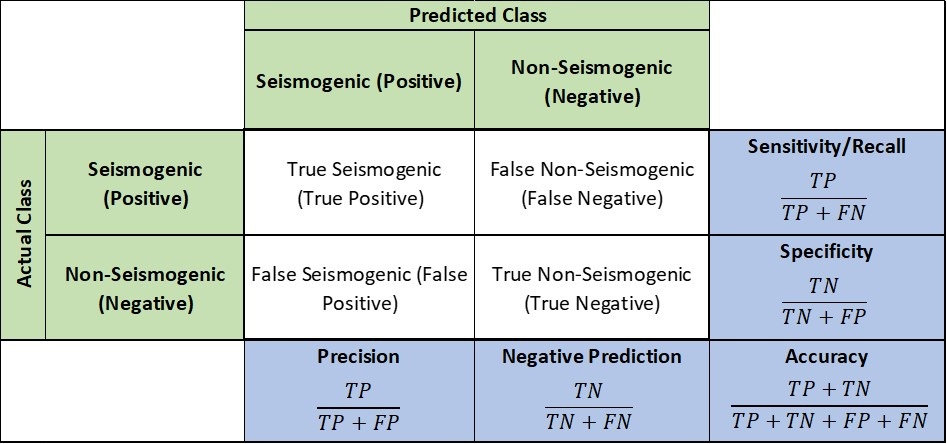

# Chosen models: Light GBM and Random Forest
- similar to 1.1 cut off magnitude study

# Model performance on validation set

F1 Score: Random Forest [0.96011817 0.53714286]
[15:36:46] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
F1 Score: XGBoost [0.96230159 0.6       ]
F1 Score: Light GBM [0.96140351 0.63507109]


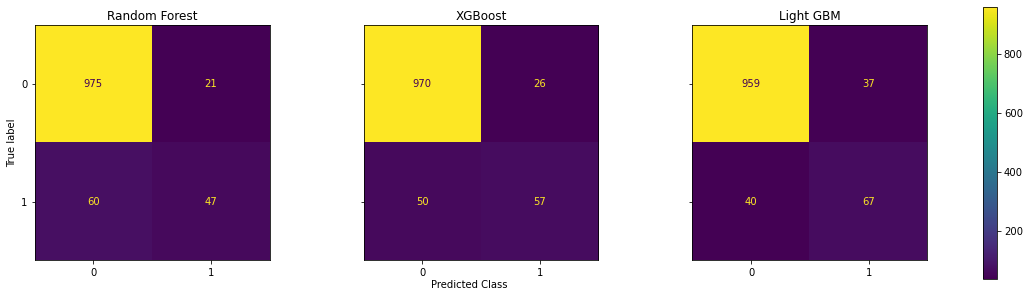

In [11]:
classifiers = {
    "Random Forest": RandomForestClassifier(max_depth= 16),
    "XGBoost": xgb.XGBClassifier(eta= 0.16462935282207308,gamma= 0.08715233968622321 , max_depth=16),
    "Light GBM": lgb.LGBMClassifier(learning_rate= 0.008472814974746676,max_depth= 32,n_estimators=1000,num_leaves= 100,class_weight='balanced')
                }


f, axes = plt.subplots(1, 3, figsize=(20, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(X_train_scaled, y_train).predict(X_test_scaled)
    print("F1 Score: %s" % key , f1_score(y_test, y_pred, average=None))
    cf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cf_matrix)
#                                  display_labels=iris.target_names)
    disp.plot(ax=axes[i], xticks_rotation=0)
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

f.text(0.4, 0.1, 'Predicted Class', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)


f.colorbar(disp.im_, ax=axes)
plt.show()
f.savefig('Validation_ConfMatrix_300dpi', dpi=300)

# Model Interpretation

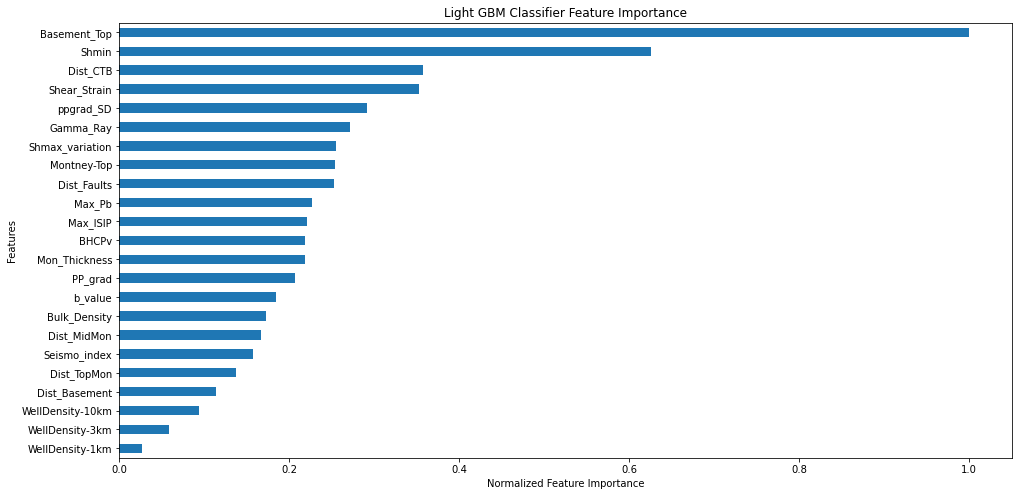

In [12]:
model = lgb.LGBMClassifier(learning_rate= 0.008472814974746676,max_depth= 32,n_estimators=1000,num_leaves= 100,class_weight='balanced',importance_type='gain')
model.fit(X_train_scaled, y_train)
feat_importances = pd.Series(model.feature_importances_, index=X_train_scaled.columns)
feat_importances = feat_importances.sort_values()/feat_importances.max()
fig = plt.gcf()
plt.title("Light GBM Classifier Feature Importance")
fig.set_figheight(8)
fig.set_figwidth(16)
plt.xlabel("Normalized Feature Importance")
plt.ylabel("Features")
feat_importances.plot(kind='barh')
plt.savefig('LGBM_C_FInorm_GOP_200dpi.png', dpi=200)

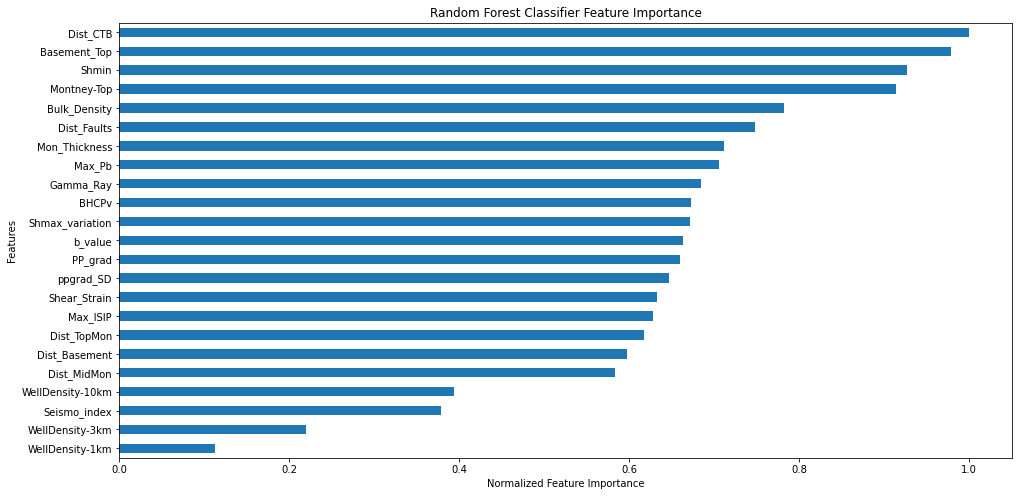

In [13]:
feature_names = [f'feature {i}' for i in range(X_train_scaled.shape[1])]
forest = RandomForestClassifier(max_depth= 16)
forest.fit(X_train_scaled, y_train)
feat_importances = pd.Series(forest.feature_importances_, index=X_train_scaled.columns)
feat_importances = feat_importances.sort_values()/feat_importances.max()
fig = plt.gcf()
plt.title("Random Forest Classifier Feature Importance")
fig.set_figheight(8)
fig.set_figwidth(16)
plt.xlabel("Normalized Feature Importance")
plt.ylabel("Features")
feat_importances.plot(kind='barh')
plt.savefig('RF_C_FInorm_200dpi.png', dpi=200)

## SHAP plots

In [14]:
model = lgb.LGBMClassifier(learning_rate= 0.008472814974746676,max_depth= 32,n_estimators=1000,num_leaves= 100,class_weight='balanced').fit(X_train_scaled, y_train)

# compute SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_scaled)


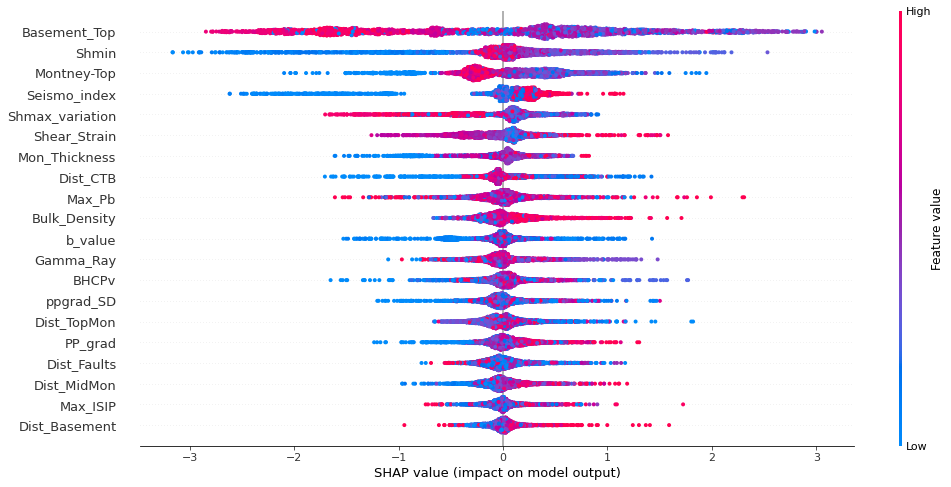

In [15]:
shap.summary_plot(shap_values[1], X_train_scaled,show=False)
fig = plt.gcf()
fig.set_figheight(8)
fig.set_figwidth(16)
plt.savefig('LGBM_C_SHAP_summary_200dpi.png', dpi=200)

In [16]:
modelrf = RandomForestClassifier(max_depth= 16).fit(X_train_scaled, y_train)

# compute SHAP values
explainer = shap.TreeExplainer(modelrf)
shap_values = explainer.shap_values(X_train_scaled)

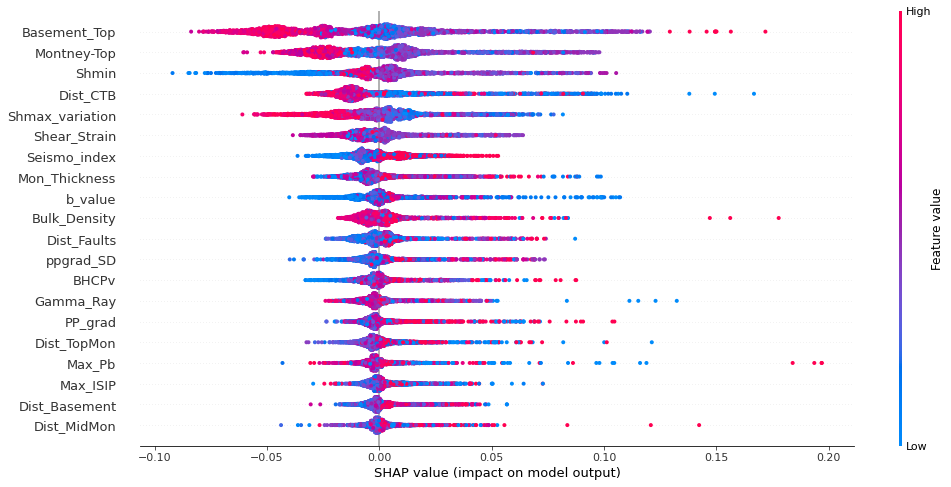

In [17]:
#fig, ax = plt.subplots(figsize=(30, 30))
fig = shap.summary_plot(shap_values[1], X_train_scaled,show=False)
fig = plt.gcf()
fig.set_figheight(8)
fig.set_figwidth(16)
plt.savefig('RF_C_SHAP_summary_200dpi.png', dpi=200)

# ROC curve

[12:30:50] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


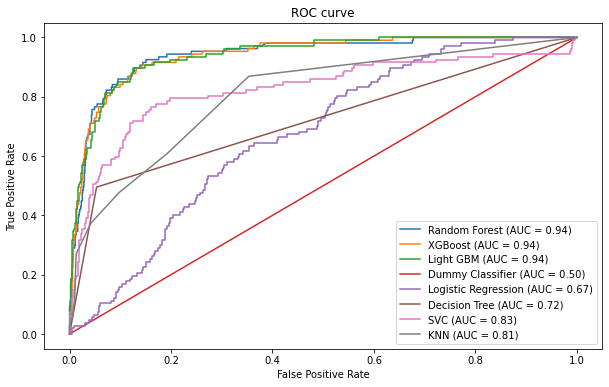

In [5]:

from sklearn.pipeline import make_pipeline
fig, ax = plt.subplots(figsize=(10, 6))

rf_model = make_pipeline(
    RandomForestClassifier(max_depth= 16))
rf_model.fit(X_train_scaled, y_train)

xgb_model = make_pipeline(
    xgb.XGBClassifier(eta= 0.16462935282207308,gamma= 0.08715233968622321 , max_depth=16, use_label_encoder=False))
xgb_model.fit(X_train_scaled, y_train)

lgbm_model = make_pipeline(
    lgb.LGBMClassifier(learning_rate= 0.008472814974746676,max_depth= 32,n_estimators=1000,num_leaves= 100,class_weight='balanced'))
lgbm_model.fit(X_train_scaled, y_train)

dm_model = make_pipeline(
    DummyClassifier(strategy="most_frequent"))
dm_model.fit(X_train_scaled, y_train)

lr_model = make_pipeline(
    LogisticRegression(C=0.016599520497738517, max_iter=100,class_weight='balanced'))
lr_model.fit(X_train_scaled, y_train)

dt_model = make_pipeline(
    DecisionTreeClassifier(max_depth= 38))
dt_model.fit(X_train_scaled, y_train)

svc_model = make_pipeline(
    SVC(C= 114.80322823456191,gamma=0.7148890027331399))
svc_model.fit(X_train_scaled, y_train)

knn_model = make_pipeline(
    KNeighborsClassifier(leaf_size= 37,n_neighbors= 8))
knn_model.fit(X_train_scaled, y_train)



models = [
    ("Random Forest", rf_model),
    ("XGBoost", xgb_model),
    ("Light GBM", lgbm_model),
    ("Dummy Classifier", dm_model),
    ("Logistic Regression", lr_model),
    ("Decision Tree", dt_model),
    ("SVC", svc_model),
    ("KNN", knn_model),
]

model_displays = {}
for name, pipeline in models:
    model_displays[name] = plot_roc_curve(
        pipeline, X_test_scaled, y_test, ax=ax, name=name)
_ = ax.set_title('ROC curve')
fig.savefig('ROC_all_200dpi', dpi=200)

# preprocessing grid dataset

In [6]:
X = df_grid.drop(columns=['Montney-Mid','Lower_Form','Dist_Lower_Form','WellDensity-5km','FID','POINT_X','POINT_Y'])

X_imp = imputer.transform(X)
 
X_scaled = scaler.transform(X_imp) # transforming the train split
X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

In [19]:
model = lgb.LGBMClassifier(learning_rate= 0.019429770022979964,max_depth= 32,n_estimators=200,num_leaves= 80,class_weight='balanced')
model.fit(X_train_scaled, y_train)
prob = model.predict_proba(X_scaled)
df = pd.DataFrame(prob)
df.to_excel(r'C:\Users\aamini\Desktop\GeoscienceBC Project\Project\lgbprob.xlsx')

In [20]:
prob

array([[0.98730015, 0.01269985],
       [0.98727513, 0.01272487],
       [0.98730015, 0.01269985],
       ...,
       [0.85142413, 0.14857587],
       [0.85581024, 0.14418976],
       [0.85581024, 0.14418976]])

# Model Result

In [7]:
classifiers = {
    "Random Forest": RandomForestClassifier(max_depth= 16),
    "XGBoost": xgb.XGBClassifier(eta= 0.16462935282207308,gamma= 0.08715233968622321 , max_depth=16, use_label_encoder=False),
    "Light GBM": lgb.LGBMClassifier(learning_rate= 0.008472814974746676,max_depth= 32,n_estimators=1000,num_leaves= 100,class_weight='balanced')
                }

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(X_train_scaled, y_train).predict_proba(X_scaled)
    df = pd.DataFrame(y_pred)
#    filename = (i)
    filename = "Montney grid_Prob_" + str(key) + ".xlsx"
    df.to_excel(filename)

[12:34:39] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
